In [1]:
import pandas as pd
import numpy as np
import copy
import json

gradcpt_data = pd.read_csv(f'data/res/all_subjects_gradcpt.csv')

In [2]:
gradcpt_data.head()

,Timestamp,Subject,Session,Trial,Mountain,Button Pressed,Response Time,Smoothed VTC
0,1.711973e+09,2,1,0,False,True,493.792057,0.708892
1,1.711973e+09,2,1,1,False,True,608.792067,0.711862
2,1.711973e+09,2,1,2,False,True,492.748976,0.719787
3,1.711973e+09,2,1,3,False,True,577.411890,0.735721
4,1.711973e+09,2,1,4,False,True,681.189060,0.762475


### Add omissions and lapses 

In [3]:
# Create a single column with categorical labels
conditions = [
    (gradcpt_data['Mountain'] & gradcpt_data['Button Pressed']),
    (~gradcpt_data['Mountain'] & ~gradcpt_data['Button Pressed']),
    (gradcpt_data['Mountain'] & ~gradcpt_data['Button Pressed']),
    (~gradcpt_data['Mountain'] & gradcpt_data['Button Pressed'])
]
choices = ['Lapse', 'Omission', 'Correct', 'Baseline']
gradcpt_data['Condition'] = np.select(conditions, choices)

In [4]:
gradcpt_data.head()

,Timestamp,Subject,Session,Trial,Mountain,Button Pressed,Response Time,Smoothed VTC,Condition
0,1.711973e+09,2,1,0,False,True,493.792057,0.708892,Baseline
1,1.711973e+09,2,1,1,False,True,608.792067,0.711862,Baseline
2,1.711973e+09,2,1,2,False,True,492.748976,0.719787,Baseline
3,1.711973e+09,2,1,3,False,True,577.411890,0.735721,Baseline
4,1.711973e+09,2,1,4,False,True,681.189060,0.762475,Baseline


## Accuracy

In [5]:
import pandas as pd

# Assuming gradcpt_data is your DataFrame

# Group the data by 'Subject' and calculate lapses for mountain scenes
lapse_data = gradcpt_data[gradcpt_data['Mountain']]
lapses_per_subject = lapse_data.groupby('Subject')['Button Pressed'].mean() * 100

# Group the data by 'Subject' and calculate omission errors for city scenes
omission_data = gradcpt_data[~gradcpt_data['Mountain']]
omissions_per_subject = omission_data.groupby('Subject')['Button Pressed'].apply(lambda x: (1 - x.mean()) * 100)

# Get overall percentages and ranges
overall_percentage_lapses = lapses_per_subject.mean()
overall_percentage_omissions = omissions_per_subject.mean()
range_lapses = (lapses_per_subject.min(), lapses_per_subject.max())
range_omissions = (omissions_per_subject.min(), omissions_per_subject.max())

print(f"Overall Percentage of Lapses: {overall_percentage_lapses:.2f}%")
print(f"Range of Lapses across Subjects: {range_lapses[0]:.2f}% to {range_lapses[1]:.2f}%")
print(f"Overall Percentage of Omission Errors: {overall_percentage_omissions:.2f}%")
print(f"Range of Omission Errors across Subjects: {range_omissions[0]:.2f}% to {range_omissions[1]:.2f}%")


Overall Percentage of Lapses: 32.79%
Range of Lapses across Subjects: 12.18% to 61.64%
Overall Percentage of Omission Errors: 1.28%
Range of Omission Errors across Subjects: 0.10% to 5.09%


## Performance Decrements

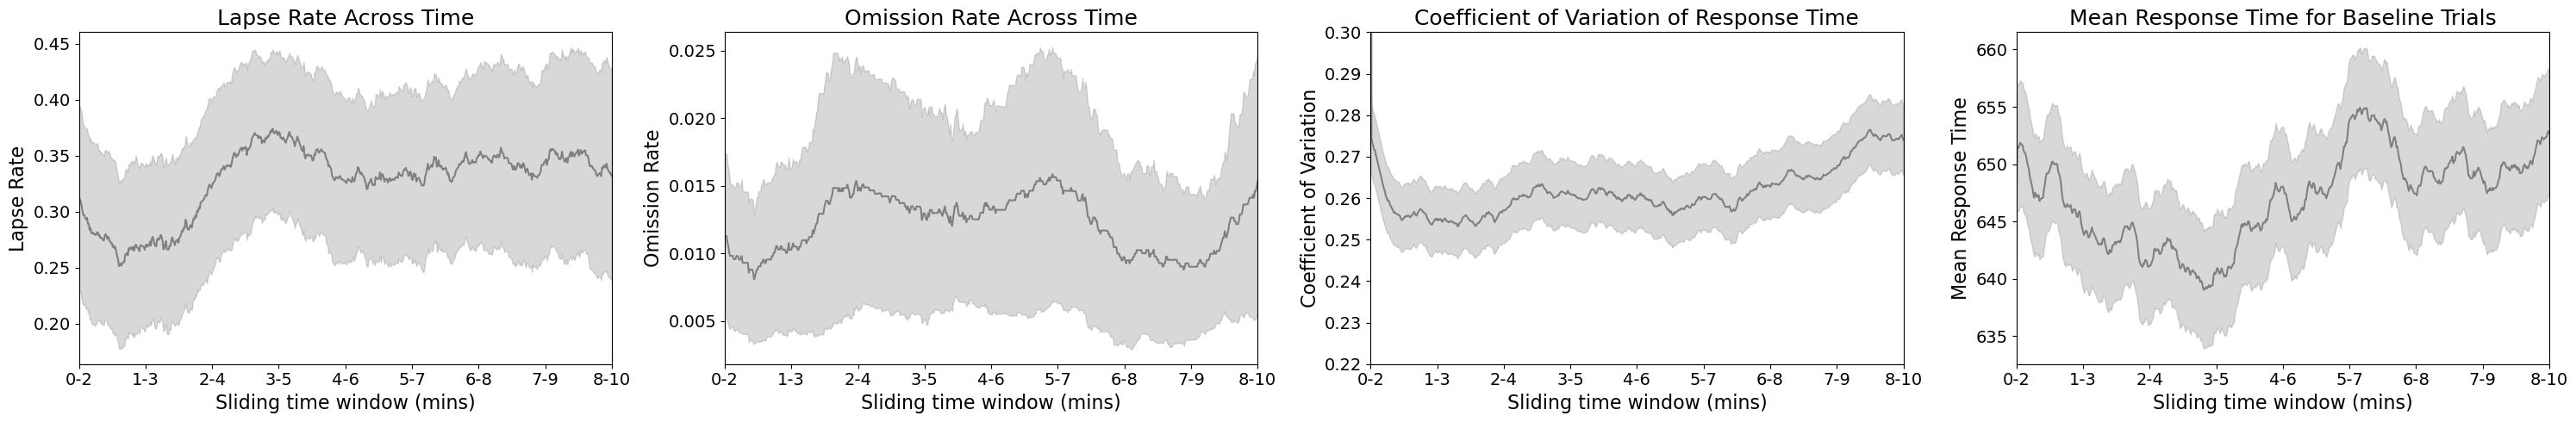

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

n_samples = 750

# Create a copy and prepare data
data_copy = gradcpt_data.copy()
window_size = 150  # 2 minutes window
half_window = window_size // 2
lapse_rates = []
omission_rates = []
lapse_ci = []
omission_ci = []
cv_rates = []
cv_ci = []
mean_rt_rates = []
mean_rt_ci = []

# Calculate rates and confidence intervals for each window position
for center in range(half_window, n_samples - half_window + 1):
    window_start = center - half_window
    window_end = center + half_window
    window_data = data_copy[(data_copy['Trial'] >= window_start) & (data_copy['Trial'] < window_end)]
    grouped_data = window_data.groupby(['Subject', 'Session', 'Condition']).size().unstack(fill_value=0)
    grouped_data['Mountain Trials'] = grouped_data['Correct'] + grouped_data['Lapse']
    grouped_data['City Trials'] = grouped_data['Baseline'] + grouped_data['Omission']
    
    # Lapse and Omission rates
    if grouped_data['Mountain Trials'].sum() > 0:
        lapse_rate = grouped_data['Lapse'].sum() / grouped_data['Mountain Trials'].sum()
        lapse_se = np.std(grouped_data['Lapse'] / grouped_data['Mountain Trials'], ddof=1) / np.sqrt(grouped_data['Lapse'].count())
        lapse_ci.append(1.96 * lapse_se)
    else:
        lapse_rate = np.nan
        lapse_ci.append(np.nan)

    if grouped_data['City Trials'].sum() > 0:
        omission_rate = grouped_data['Omission'].sum() / grouped_data['City Trials'].sum()
        omission_se = np.std(grouped_data['Omission'] / grouped_data['City Trials'], ddof=1) / np.sqrt(grouped_data['Omission'].count())
        omission_ci.append(1.96 * omission_se)
    else:
        omission_rate = np.nan
        omission_ci.append(np.nan)

    # Coefficient of Variation (CV) for Baseline Response Times
    baseline_responses = window_data[(window_data['Condition'] == 'Baseline') & (window_data['Response Time'].notna())]['Response Time']
    if len(baseline_responses) > 1:
        mean_rt = np.mean(baseline_responses)
        std_rt = np.std(baseline_responses, ddof=1)
        cv_rt = std_rt / mean_rt if mean_rt != 0 else np.nan
        cv_se = (1 / mean_rt) * np.sqrt((std_rt**2 / len(baseline_responses)) - (cv_rt**2 / len(baseline_responses)))
        cv_ci.append(1.96 * cv_se)
        mean_rt_ci.append(1.96 * (std_rt / np.sqrt(len(baseline_responses))))
    else:
        cv_rt = np.nan
        cv_ci.append(np.nan)
        mean_rt = np.nan
        mean_rt_ci.append(np.nan)

    lapse_rates.append(lapse_rate)
    omission_rates.append(omission_rate)
    cv_rates.append(cv_rt)
    mean_rt_rates.append(mean_rt)

# Convert to DataFrame for plotting
rates_df = pd.DataFrame({
    'Lapse Rate': lapse_rates,
    'Omission Rate': omission_rates,
    'Lapse CI': lapse_ci,
    'Omission CI': omission_ci,
    'CV Rate': cv_rates,
    'CV CI': cv_ci,
    'Mean RT': mean_rt_rates,
    'Mean RT CI': mean_rt_ci,
    'Center Sample': range(half_window, n_samples - half_window + 1)
})

# Plotting with four subplots side by side and error zones
fig, axs = plt.subplots(1, 4, figsize=(30, 5))  # Adjusted for four plots

# Lapse Rate Plot
axs[0].plot(rates_df['Center Sample'], rates_df['Lapse Rate'], label='Lapse Rate', color='gray')
axs[0].fill_between(rates_df['Center Sample'], rates_df['Lapse Rate'] - rates_df['Lapse CI'], rates_df['Lapse Rate'] + rates_df['Lapse CI'], color='gray', alpha=0.3)
axs[0].set_title('Lapse Rate Across Time', fontsize=18)
axs[0].set_ylabel('Lapse Rate', fontsize=16)

# Omission Rate Plot
axs[1].plot(rates_df['Center Sample'], rates_df['Omission Rate'], label='Omission Rate', color='gray')
axs[1].fill_between(rates_df['Center Sample'], rates_df['Omission Rate'] - rates_df['Omission CI'], rates_df['Omission Rate'] + rates_df['Omission CI'], color='gray', alpha=0.3)
axs[1].set_title('Omission Rate Across Time', fontsize=18)
axs[1].set_ylabel('Omission Rate', fontsize=16)

# Coefficient of Variation Plot
axs[2].plot(rates_df['Center Sample'], rates_df['CV Rate'], label='CV of Response Time', color='gray')
axs[2].fill_between(rates_df['Center Sample'], rates_df['CV Rate'] - rates_df['CV CI'], rates_df['CV Rate'] + rates_df['CV CI'], color='gray', alpha=0.3)
axs[2].set_title('Coefficient of Variation of Response Time', fontsize=18)
axs[2].set_ylabel('Coefficient of Variation', fontsize=16)
axs[2].set_ylim(0.22, 0.3)

# Mean Response Time Plot
axs[3].plot(rates_df['Center Sample'], rates_df['Mean RT'], label='Mean Response Time', color='gray')
axs[3].fill_between(rates_df['Center Sample'], rates_df['Mean RT'] - rates_df['Mean RT CI'], rates_df['Mean RT'] + rates_df['Mean RT CI'], color='gray', alpha=0.3)
axs[3].set_title('Mean Response Time for Baseline Trials', fontsize=18)
axs[3].set_ylabel('Mean Response Time', fontsize=16)

# Define the tick labels for the sliding windows in minutes
x_labels = ["0-2", "1-3", "2-4", "3-5", "4-6", "5-7", "6-8", "7-9", "8-10"]

# Assuming the step between each window corresponds to the changes in minutes
# Calculate the x-tick positions; assuming that each tick represents a range of 150 samples in a total of 750
# This would be every 150/2 = 75 samples since each window is 150 samples
tick_positions = np.linspace(half_window, n_samples - half_window, len(x_labels))

# Update each subplot to use the specific x-ticks and labels
for ax in axs:
    ax.set_xticks(tick_positions)  # Set the ticks at the calculated positions
    ax.set_xticklabels(x_labels, fontsize=14)  # Set the custom labels
    ax.tick_params(axis='y', labelsize=14)
    ax.set_xlim(half_window, n_samples - half_window)
    ax.set_xlabel('Sliding time window (mins)', fontsize=16)  # Common x-label

plt.tight_layout()
plt.savefig('performance_decrements.png', dpi=300)  # Save the figure as a PNG file with high resolution
plt.show()


In [7]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats

# Sample data, replace this with your actual dataframe loading if not already in the environment
# Assuming gradcpt_data is loaded and structured with the necessary columns

n_samples = 750
window_size = 150  # 2 minutes window equivalent, assuming each trial corresponds to about 0.16 minutes
half_window = window_size // 2

# Initialize lists to store results
data_list = []

# Iterate over each subject and session
for (subj, sess), group in gradcpt_data.groupby(['Subject', 'Session']):
    for center in range(half_window, n_samples - half_window + 1):
        window_start = center - half_window
        window_end = center + half_window
        window_data = group[(group['Trial'] >= window_start) & (group['Trial'] < window_end)]
        
        # Calculate metrics within the window
        lapse_rate = window_data[window_data['Condition'] == 'Lapse'].shape[0] / window_data[window_data['Condition'].isin(['Correct', 'Lapse'])].shape[0] if window_data[window_data['Condition'].isin(['Correct', 'Lapse'])].shape[0] > 0 else np.nan
        omission_rate = window_data[window_data['Condition'] == 'Omission'].shape[0] / window_data[window_data['Condition'].isin(['Baseline', 'Omission'])].shape[0] if window_data[window_data['Condition'].isin(['Baseline', 'Omission'])].shape[0] > 0 else np.nan

        # Handle CV and mean RT for Baseline trials
        baseline_data = window_data[window_data['Condition'] == 'Baseline']
        mean_rt = baseline_data['Response Time'].mean() if not baseline_data.empty else np.nan
        std_rt = baseline_data['Response Time'].std(ddof=1) if not baseline_data.empty and len(baseline_data) > 1 else np.nan
        cv_rt = std_rt / mean_rt if mean_rt and std_rt and mean_rt > 0 else np.nan

        # Append results to the list
        data_list.append({
            'Subject': subj,
            'Session': sess,
            'Center Sample': center,
            'Lapse Rate': lapse_rate,
            'Omission Rate': omission_rate,
            'CV Rate': cv_rt,
            'Mean RT': mean_rt
        })

# Convert list to DataFrame
rates_df = pd.DataFrame(data_list)

# Step 2: Calculate Slopes for Each Subject Across Windows
def calculate_slope(y):
    # Drop NaN values from y and reset the index to ensure continuity
    y_clean = y.dropna().reset_index(drop=True)
    if len(y_clean) < 2:  # Need at least two points to fit a line
        return np.nan
    
    # Create a DataFrame for x with a continuous range and a constant for the intercept
    x = pd.DataFrame({
        'const': 1,  # Add a constant term for the intercept
        'x': range(len(y_clean))  # Use a range that matches the length of the cleaned y
    })

    # Fit the model using OLS
    model = sm.OLS(y_clean, x)  # No need to use .loc as indices are aligned
    results = model.fit()
    return results.params['x']  # Return the slope (rate of change)

# Usage of the function in grouping and applying
slopes_df = rates_df.groupby('Subject').apply(lambda df: pd.Series({
    'LapseRateSlope': calculate_slope(df['Lapse Rate']),
    'OmissionRateSlope': calculate_slope(df['Omission Rate']),
    'CV_RTSlope': calculate_slope(df['CV Rate']),
    'MeanRTSlope': calculate_slope(df['Mean RT'])
})).reset_index()

# Output the results
print(slopes_df)


# Step 3: Conduct one-sample t-tests
results = {}
for column in slopes_df.columns:
    t_stat, p_val = stats.ttest_1samp(slopes_df[column].dropna(), 0)
    results[column] = {'t-statistic': t_stat, 'p-value': p_val}

# Output the results
for metric, result in results.items():
    print(f"The rate of change for {metric}: t-statistic = {result['t-statistic']:.2f}, P-value = {result['p-value']:.3f}")


   Subject  LapseRateSlope  OmissionRateSlope    CV_RTSlope  MeanRTSlope
0        2       -0.000171      -3.355381e-06 -5.089516e-05    -0.025695
1        3        0.000158       2.405202e-05  4.262852e-05     0.009116
2        4        0.000422      -3.840148e-05 -2.800704e-05     0.045908
3        5        0.000011      -5.530856e-06 -4.161108e-06    -0.047854
4        6        0.000079       1.387056e-06 -2.780844e-05    -0.009046
5        7        0.000156      -8.944334e-06  3.115281e-05    -0.037213
6        8        0.000059      -4.617728e-06 -5.386075e-05    -0.058929
7        9        0.000022      -5.817152e-07 -2.334666e-05     0.042739
8       10       -0.000012       5.287777e-06  1.744788e-07    -0.000666
9       11       -0.000047       7.938535e-08 -1.779929e-05    -0.016282
The rate of change for Subject: t-statistic = 6.79, P-value = 0.000
The rate of change for LapseRateSlope: t-statistic = 1.36, P-value = 0.207
The rate of change for OmissionRateSlope: t-statistic 

/tmp/ipykernel_50403/3890596808.py:66: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  slopes_df = rates_df.groupby('Subject').apply(lambda df: pd.Series({


## RT Variability

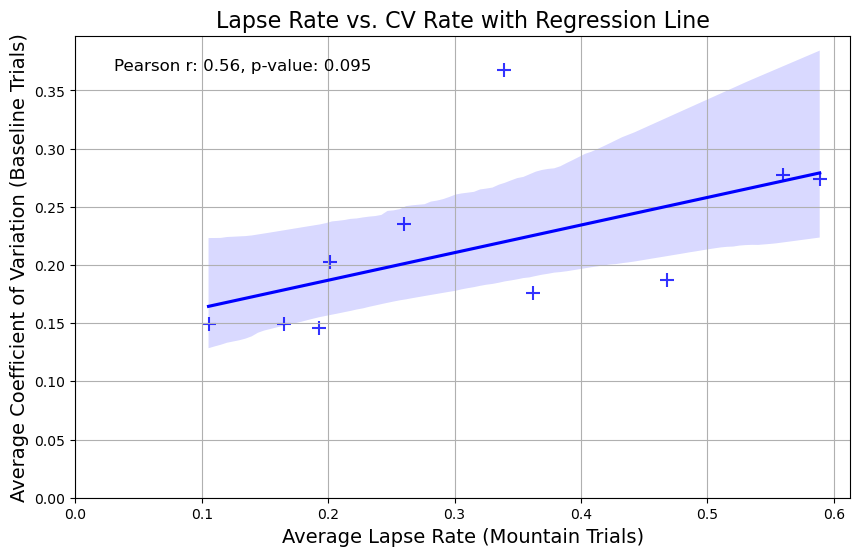

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Use Seaborn to create a scatter plot with a regression line
plt.figure(figsize=(10, 6))
ax = sns.regplot(x='Lapse Rate', y='CV Rate', data=aggregated_data,
                 color='blue', marker='+', scatter_kws={'s': 100})

# Calculate Pearson correlation coefficient and p-value
pearson_coef, p_value = stats.pearsonr(aggregated_data['Lapse Rate'].dropna(), aggregated_data['CV Rate'].dropna())

# Annotate the plot with the Pearson correlation coefficient and p-value
plt.text(0.05, 0.95, f'Pearson r: {pearson_coef:.2f}, p-value: {p_value:.3f}',
         ha='left', va='top', transform=ax.transAxes, fontsize=12)

plt.title('Lapse Rate vs. CV Rate with Regression Line', fontsize=16)
plt.xlabel('Average Lapse Rate (Mountain Trials)', fontsize=14)
plt.ylabel('Average Coefficient of Variation (Baseline Trials)', fontsize=14)
plt.xlim(left=0)  # Start x-axis from 0
plt.ylim(bottom=0)  # Start y-axis from 0
plt.grid(True)

plt.show()

### plot VTC

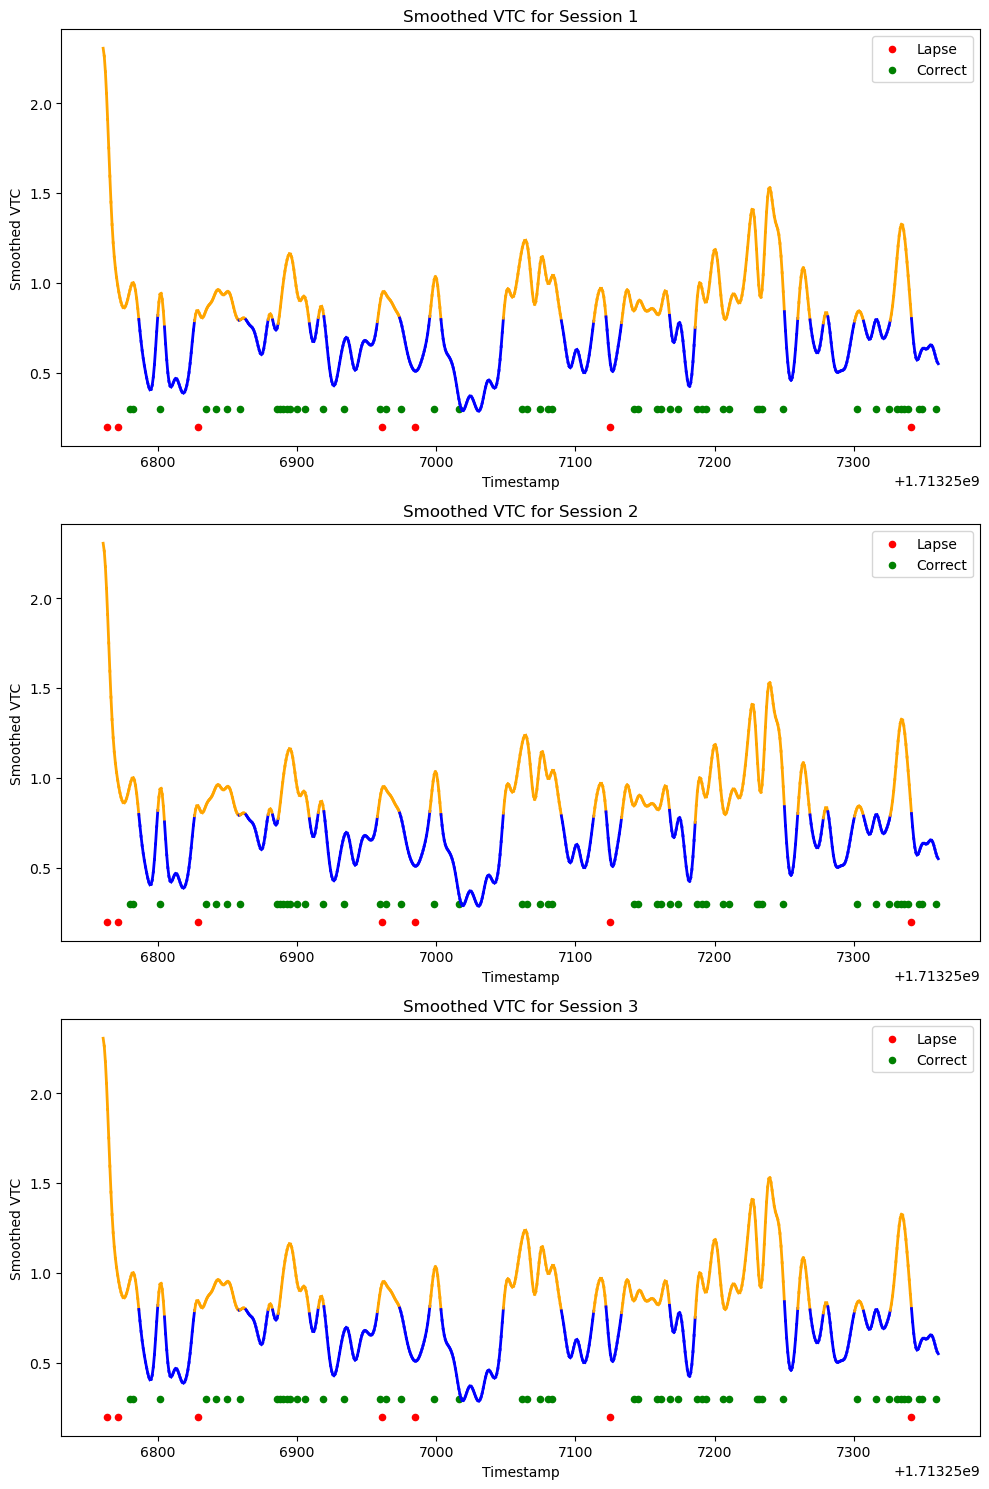

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming gradcpt_data is already loaded

# Define the figure and subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15))  # Adjust the figure size to fit three plots

# Trials to plot
sessions = [1, 2, 3]

# Iterate over each subplot and plot each trial
for ax, session in zip(axes, sessions):
    # Filter data for the current trial and Subject 11
    trial_data = gradcpt_data[(gradcpt_data['Session'] == trial) & (gradcpt_data['Subject'] == 11)]

    # Calculate the mean of Smoothed VTC
    mean_vtc = trial_data['Smoothed VTC'].mean()

    # Plotting VTC data
    for i in range(len(trial_data) - 1):
        x_values = trial_data['Timestamp'][i:i+2]
        y_values = trial_data['Smoothed VTC'][i:i+2]
        color = 'orange' if y_values.mean() > mean_vtc else 'blue'
        ax.plot(x_values, y_values, color=color, linewidth=2)

    # Add dots for Lapses and Corrects at fixed y positions with smaller size
    conditions = [('Lapse', 'red', 0.2), ('Correct', 'green', 0.3)]
    for condition, marker_color, y_position in conditions:
        condition_data = trial_data[trial_data['Condition'] == condition]
        ax.scatter(condition_data['Timestamp'], [y_position] * len(condition_data), color=marker_color, s=20, label=condition)

    # Set titles and labels
    ax.set_title(f'Smoothed VTC for Session {session}')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Smoothed VTC')

    # Add legend to distinguish conditions
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.savefig('erik_zones_trials.png', dpi=300)  # Save the figure as a PNG file with high resolution
plt.show()

### Error rate

In [12]:
import pandas as pd

# Sample data loading (replace this with your actual DataFrame)
# gradcpt_data = pd.DataFrame(...)

# Define error conditions
error_conditions = ['Lapse', 'Omission']

# Filter data for error conditions
error_data = gradcpt_data[gradcpt_data['Condition'].isin(error_conditions)]

# Calculate error rate: count of errors divided by total trials per subject, then multiply by 100 to get percentage
error_rates = (error_data.groupby('Subject').size() / gradcpt_data.groupby('Subject').size() * 100).reset_index(name='Error Rate (%)')

# Sort the subjects by error rate in descending order
error_rates_sorted = error_rates.sort_values('Error Rate (%)', ascending=False)

# Calculate the average error rate across all subjects and convert to percentage
average_error_rate = error_rates['Error Rate (%)'].mean()

# Print the sorted error rates and the average error rate in percentage
print(error_rates_sorted)
print("Average Error Rate across all subjects: {:.2f}%".format(average_error_rate))


   Subject  Error Rate (%)
2        4        9.600000
1        3        7.600000
5        7        5.600000
4        6        4.088889
6        8        3.688889
8       10        3.111111
3        5        2.800000
0        2        2.044444
7        9        1.644444
9       11        1.155556
Average Error Rate across all subjects: 4.13%


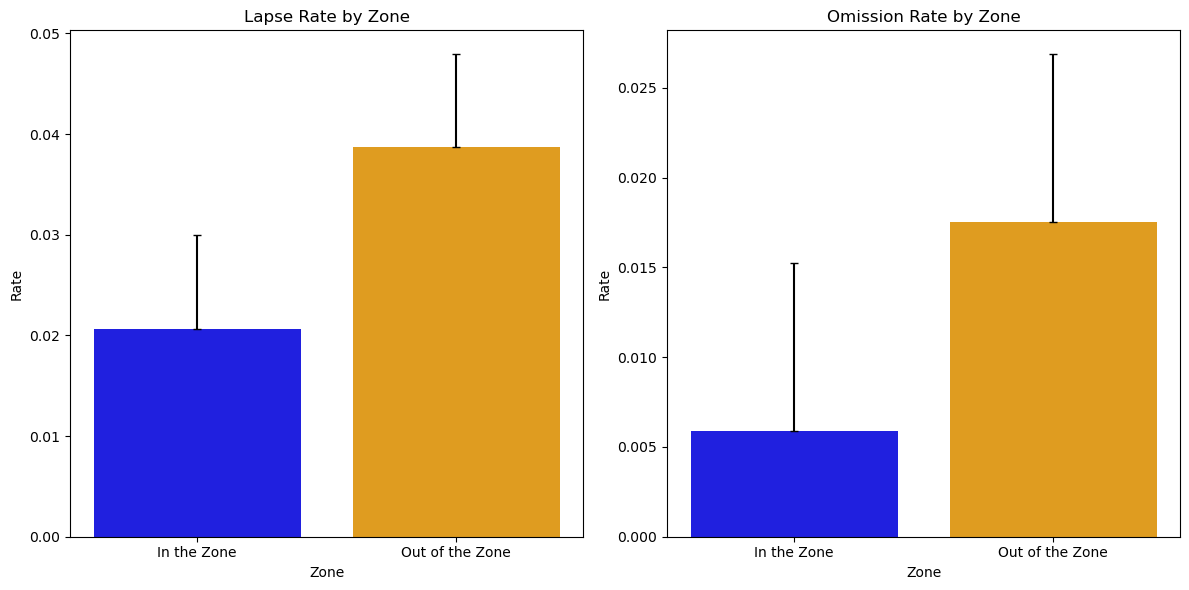

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sample DataFrame (add your DataFrame loading code here)

# Calculate the rates and standard errors for 'Lapse' and 'Omission' conditions by 'Zone'
conditions_of_interest = ['Lapse', 'Omission']
zones = gradcpt_data['Zone'].unique()

# Prepare data for plotting
plot_data = []
for condition in conditions_of_interest:
    for zone in zones:
        subset = gradcpt_data[(gradcpt_data['Condition'] == condition) & (gradcpt_data['Zone'] == zone)]
        rate = len(subset) / len(gradcpt_data[gradcpt_data['Zone'] == zone])
        se = np.sqrt(rate * (1 - rate) / len(subset))  # Binomial standard error
        plot_data.append({'Condition': condition, 'Zone': str(zone), 'Rate': rate, 'SE': se})

plot_df = pd.DataFrame(plot_data)
plot_df['Zone'] = pd.Categorical(plot_df['Zone'], categories=["1", "0"], ordered=True)
plot_df = plot_df.sort_values('Zone')

# Plotting
plt.figure(figsize=(12, 6))
for i, condition in enumerate(conditions_of_interest, 1):
    plt.subplot(1, 2, i)
    ax = sns.barplot(x='Zone', y='Rate', hue='Zone', data=plot_df[plot_df['Condition'] == condition], 
                     errorbar=None, palette={str(1): 'blue', str(0): 'orange'}, legend=False)
    plt.title(f'{condition} Rate by Zone')
    plt.xlabel('Zone')
    plt.ylabel('Rate')
    
    # Correctly placing the error bars, only upper part, without markers
    for index, patch in enumerate(ax.patches):
        height = patch.get_height()
        x = patch.get_x() + patch.get_width() / 2
        zone = plot_df[(plot_df['Condition'] == condition)]['Zone'].iloc[index]
        se = plot_df[(plot_df['Condition'] == condition) & (plot_df['Zone'] == zone)]['SE'].iloc[0]
        plt.errorbar(x, height, yerr=[[0], [se]], fmt='', color='black', capsize=3)

    # Adjust x-axis labels
    ax.set_xticks([0, 1])  # This ensures that the ticks are indeed where you expect them to be
    ax.set_xticklabels(['In the Zone', 'Out of the Zone'])

plt.tight_layout()
plt.savefig('error_by_zone.png', dpi=300)  # Save the figure as a PNG file with high resolution
plt.show()


## Backup